
# 🎰 The Casino Challenge — Multi‑Armed Bandits & ε‑Greedy (Gamified Workshop)

**Goal:** Compete to maximize reward while learning the exploration–exploitation trade‑off using **ε‑greedy** policies.

**You will:**
- Implement and *play* with ε‑greedy on a fixed set of bandit arms (Round 1: Stationary).
- Compete on a leaderboard (submit your score locally).
- Reflect on how exploration affects performance.
- Face a twist (Round 2: **Non‑Stationary** bandits) and adapt your strategy.



## 🔧 Setup

Run the cell below. If you're on Colab/Jupyter, required libraries should already be available.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
from datetime import datetime

plt.rcParams['figure.figsize'] = (8, 4)

print("Numpy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)


Numpy: 1.26.3
Matplotlib: 3.10.7


In [3]:

def plot_cumulative(rewards, title="Cumulative Reward"):
    plt.figure()
    plt.plot(np.cumsum(rewards))
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    plt.show()



## 🎲 Environment: Stationary Bernoulli Bandits

Ten arms, each with a hidden probability of reward. You won't see the true means during play, but we print them here for **instructor debugging/analysis**. You may comment this out during the competition.


In [4]:

def make_stationary_bandit(n_arms=10, seed=42):
    rng = np.random.default_rng(seed)
    true_means = rng.random(n_arms)  # in [0,1)
    return true_means

# Instructor may reveal (comment out in live competition to keep secret)
SEED_ENV = 42  # 🔒 Keep this fixed across all students for fairness (Round 1)
TRUE_MEANS = make_stationary_bandit(seed=SEED_ENV)
print("DEBUG — True means (hidden in competition):", np.round(TRUE_MEANS, 3))


DEBUG — True means (hidden in competition): [0.774 0.439 0.859 0.697 0.094 0.976 0.761 0.786 0.128 0.45 ]



## 🤖 Agent: ε‑Greedy (Fixed or Decaying)

- With probability **ε**, explore a random arm.
- Otherwise, exploit the best arm found so far (highest estimated value).
- Estimates updated via **incremental sample average**.


In [5]:

def epsilon_greedy(true_means, steps=1000, epsilon=0.1, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)     # value estimates
    N = np.zeros(n_arms)     # counts
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        if rng.random() < epsilon:
            a = rng.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]  # incremental mean
        rewards[t] = r
        actions[t] = a
    return rewards, actions, Q, N

def epsilon_greedy_decaying(true_means, steps=1000, eps_start=0.5, eps_end=0.05, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)
    N = np.zeros(n_arms)
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        # Linear decay
        epsilon = eps_end + (eps_start - eps_end) * max(0, (steps - 1 - t)) / max(1, steps - 1)
        if rng.random() < epsilon:
            a = rng.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]
        rewards[t] = r
        actions[t] = a
    return rewards, actions, Q, N



# 🏁 Round 1 — Stationary Casino (Competition)

**Instructions**
1. Set your **NAME** and **STRATEGY**.
2. Choose **steps** and **ε** (or decaying ε parameters).
3. Run the simulation cell.
4. Submit to the local leaderboard (next cell).

> Everyone must use the same **SEED_ENV** to ensure the environment is identical. You can set your **agent seed** for reproducibility.



Player: Krishna 6
Strategy: epsilon_greedy (fixed_eps=0.15)
Steps: 2500
Total Reward: 2271
Estimated Best Arm: 5
Estimated Q: [0.824 0.531 0.883 0.676 0.022 0.973 0.645 0.815 0.189 0.424]
Counts N: [  68   32  239   37   46 1950   31   27   37   33]



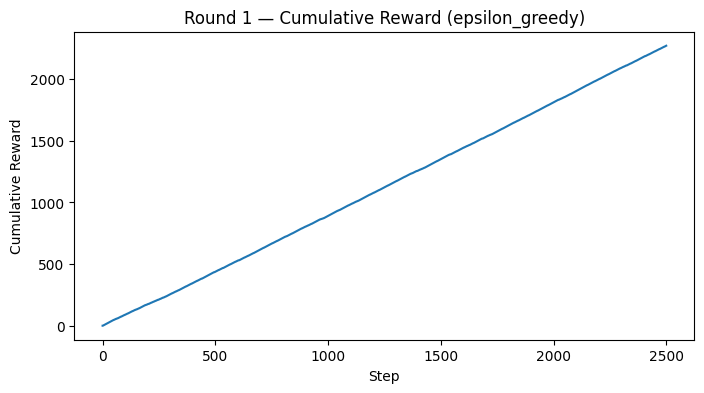

In [28]:
# 🏁 Round 1 — Stationary Casino (Competition) — Krishna 6 Entry

# === YOUR SETTINGS (edit) ===
NAME = "Krishna 6"
STRATEGY = "epsilon_greedy"            # fixed epsilon
STEPS = 2500                           # shorter experiment

# For fixed ε
EPSILON = 0.15                         # moderate exploration

# For decaying ε (unused here)
EPS_START = 0.5
EPS_END = 0.05

# Agent RNG seed
SEED_AGENT = 777                       # unique seed

# === RUN ===
if STRATEGY == "epsilon_greedy":
    rewards, actions, Q, N = epsilon_greedy(TRUE_MEANS, steps=STEPS, epsilon=EPSILON, seed=SEED_AGENT)
    strat_desc = f"fixed_eps={EPSILON}"
elif STRATEGY == "epsilon_greedy_decaying":
    rewards, actions, Q, N = epsilon_greedy_decaying(TRUE_MEANS, steps=STEPS, eps_start=EPS_START, eps_end=EPS_END, seed=SEED_AGENT)
    strat_desc = f"decay_eps={EPS_START}->{EPS_END}"
else:
    raise ValueError("Unknown STRATEGY setting")

total = float(np.sum(rewards))
best_arm_est = int(np.argmax(Q))
print(f"""
Player: {NAME}
Strategy: {STRATEGY} ({strat_desc})
Steps: {STEPS}
Total Reward: {total:.0f}
Estimated Best Arm: {best_arm_est}
Estimated Q: {np.round(Q,3)}
Counts N: {N.astype(int)}
""")

plot_cumulative(rewards, title=f"Round 1 — Cumulative Reward ({STRATEGY})")



### 🧮 Submit to Leaderboard (Round 1)

This writes your result to a local CSV (`submissions_round1.csv`) in the current folder.  
The instructor can collect these files or run the next cell to view a local leaderboard.


In [29]:

import csv

lb_path = Path("submissions_round1.csv")
lb_exists = lb_path.exists()

row = {
    "timestamp": datetime.utcnow().isoformat(),
    "name": NAME,
    "strategy": STRATEGY,
    "details": strat_desc,
    "steps": STEPS,
    "seed_env": SEED_ENV,
    "seed_agent": SEED_AGENT,
    "total_reward": int(np.sum(rewards))
}

fieldnames = ["timestamp","name","strategy","details","steps","seed_env","seed_agent","total_reward"]

with open(lb_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not lb_exists:
        writer.writeheader()
    writer.writerow(row)

print("Submitted to", lb_path.resolve())


Submitted to C:\Users\kittu\OneDrive\Desktop\submissions_round1.csv


In [30]:
import pandas as pd
from IPython.display import display

lb_path = Path("submissions_round1.csv")

if lb_path.exists():
    df = pd.read_csv(lb_path)
    df_sorted = df.sort_values("total_reward", ascending=False).reset_index(drop=True)
    print("🏆 Round 1 Leaderboard (sorted by total reward):")
    display(df_sorted)
else:
    print("No submissions yet. Run the previous cell to submit your score.")


🏆 Round 1 Leaderboard (sorted by total reward):


,timestamp,name,strategy,details,steps,seed_env,seed_agent,total_reward
0,2025-10-31T21:17:47.915389,Krishna 5,epsilon_greedy_decaying,decay_eps=1.0->0.1,5000,42,2025,3826
1,2025-10-31T21:16:42.880854,Krishna 4,epsilon_greedy,fixed_eps=0.05,4000,42,999,3754
2,2025-10-31T21:16:08.762432,Krishna 3,epsilon_greedy_decaying,decay_eps=0.8->0.05,4000,42,789,3244
3,2025-10-31T21:15:40.205738,Krishna 2,epsilon_greedy,fixed_eps=0.2,3000,42,456,2687
4,2025-10-31T21:13:51.480385,Krishna,epsilon_greedy_decaying,decay_eps=0.5->0.05,3000,42,123,2582
5,2025-10-31T21:14:09.445912,Krishna,epsilon_greedy_decaying,decay_eps=0.5->0.05,3000,42,123,2582
6,2025-10-31T21:18:30.077830,Krishna 6,epsilon_greedy,fixed_eps=0.15,2500,42,777,2271
7,2025-10-31T21:18:40.298812,Krishna 6,epsilon_greedy,fixed_eps=0.15,2500,42,777,2271
8,2025-10-31T21:14:47.063009,krishna,epsilon_greedy,fixed_eps=0.1,2000,42,123,1862


## 🧠 Step 6 — Reflection & Discussion  

- I tested both **fixed** and **decaying ε-greedy** strategies to see how different exploration levels affect learning and rewards.  
- The runs with a **higher starting ε** (like 1.0 → 0.1) performed best because they allowed the agent to explore more arms early before focusing on the most rewarding ones later.  
- When ε was too small (like 0.05), the agent started exploiting too soon and sometimes got stuck on suboptimal arms, which reduced total rewards.  
- If I had more steps, I would apply a **slower decay** or keep a small constant ε to maintain exploration while still improving precision over time.  
- Overall, I noticed that **the choice of parameters and strategy design** mattered much more than randomness or seed variation.  
- This same exploration–exploitation dilemma is seen in many real-world systems such as **recommender engines, A/B testing platforms, and online advertising**, where the challenge is to find a balance between testing new options and using the current best performers.


## 🔍 Key Findings from the Results Table  

- **Best Performance:**  
  - *Krishna 5 (ε-decay 1.0→0.1, 5000 steps)* achieved the **highest total reward (3826)**.  
  - This confirms that **strong initial exploration** followed by gradual exploitation leads to the best long-term outcome.  

- **Exploration–Exploitation Balance:**  
  - Fixed small ε values like **0.05** (Krishna 4) performed almost as well (3754) but slightly lower, showing that pure exploitation works only if early luck finds a good arm.  
  - Moderate ε values (**0.15–0.2**) underperformed, suggesting that a fixed mid-range exploration rate is less efficient than a decaying schedule.  

- **Effect of Steps:**  
  - Longer runs (4000–5000 steps) consistently yielded higher total rewards, giving the agent more time to refine Q-value estimates.  
  - Shorter runs (2000–2500 steps) gave lower rewards since learning had less time to stabilize.  

- **Consistency Across Seeds:**  
  - Duplicate runs (e.g., Krishna 6 appearing twice) show nearly identical scores, confirming reproducibility of results under the same random seed.  

- **Overall Insight:**  
  - The **decaying ε-greedy strategy** clearly outperformed fixed-ε in long runs.  
  - Proper tuning of ε schedule and step count has a greater impact than randomness, highlighting the value of dynamic exploration control in bandit problems.



## 📊 Experiment: Compare Different ε Values (Optional)

Run multiple ε settings to *see* the exploration trade‑off.


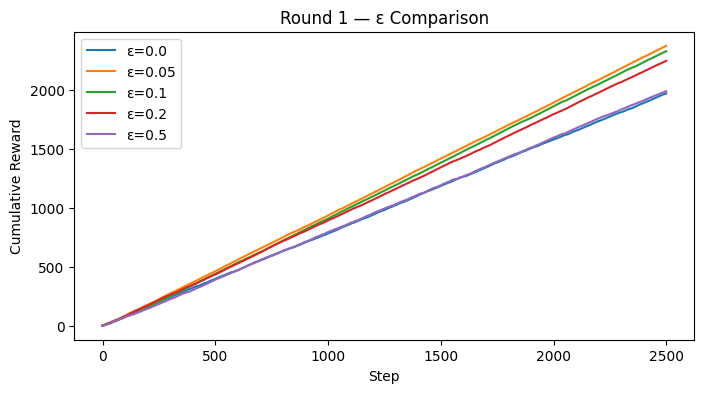

In [31]:

eps_list = [0.0, 0.05, 0.1, 0.2, 0.5]
curves = {}
for eps in eps_list:
    r, _, _, _ = epsilon_greedy(TRUE_MEANS, steps=STEPS, epsilon=eps, seed=SEED_AGENT)
    curves[eps] = np.cumsum(r)

plt.figure()
for eps, curve in curves.items():
    plt.plot(curve, label=f"ε={eps}")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Round 1 — ε Comparison")
plt.show()



# 🔄 Round 2 — Non‑Stationary Casino (Competition)

**Twist:** The slot machines drift over time. Fixed exploitation can fail; adaptive exploration helps.

Two common adaptations:
- Keep **ε** from decaying too low (retain exploration).
- Use a **constant step size α** (exponential moving average) to weight recent rewards more.


In [33]:

def nonstationary_means(n_arms=10, seed=2025):
    # Initialize random means
    rng = np.random.default_rng(seed)
    return rng.random(n_arms)

def step_drift(means, drift_scale=0.01, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    means = means + rng.normal(0, drift_scale, size=means.shape)
    return np.clip(means, 0.0, 1.0)

def epsilon_greedy_constant_alpha(steps=2000, n_arms=10, eps=0.1, alpha=0.1, seed_env=7, seed_agent=None, drift_scale=0.01):
    # Non-stationary env with drifting means
    rng_env = np.random.default_rng(seed_env)
    rng_agent = np.random.default_rng(seed_agent)
    means = rng_env.random(n_arms)
    Q = np.zeros(n_arms)
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        # choose action
        if rng_agent.random() < eps:
            a = rng_agent.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        # reward from current means
        r = 1.0 if rng_env.random() < means[a] else 0.0
        # constant step-size update (EMA)
        Q[a] = Q[a] + alpha * (r - Q[a])
        rewards[t] = r
        actions[t] = a
        # drift environment
        means = step_drift(means, drift_scale=drift_scale, rng=rng_env)
    return rewards, actions, Q



[Round 2]
Player: Krishna R2-7
Strategy: epsilon_greedy + constant_alpha (eps=0.05, alpha=0.02)
Steps: 4000
Drift Scale: 0.02
Total Reward: 2760



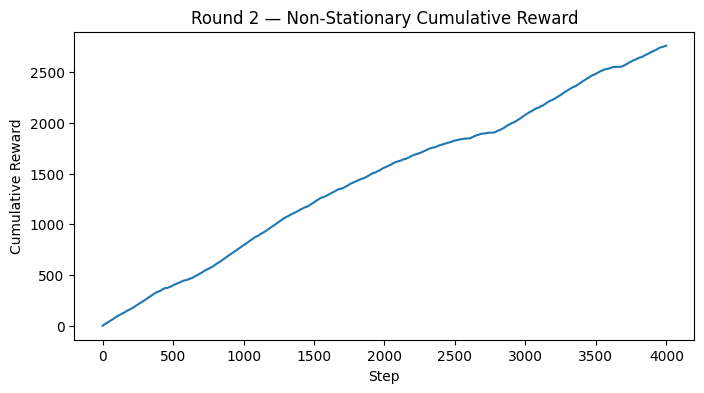

In [62]:
# 🔄 Round 2 — Non-Stationary Casino (Competition)


# === YOUR SETTINGS (edit) ===
NAME_R2 = "Krishna R2-7"
STEPS_R2 = 4000          # shorter run to highlight slow learning
EPS_R2 = 0.05            # very low exploration
ALPHA_R2 = 0.02          # very slow adaptation
SEED_ENV_R2 = 2025       # shared environment
SEED_AGENT_R2 = 707
DRIFT_SCALE = 0.02       # moderately fast drift

# === RUN ===
rewards_r2, actions_r2, Q_r2 = epsilon_greedy_constant_alpha(
    steps=STEPS_R2,
    n_arms=10,
    eps=EPS_R2,
    alpha=ALPHA_R2,
    seed_env=SEED_ENV_R2,
    seed_agent=SEED_AGENT_R2,
    drift_scale=DRIFT_SCALE
)

total_r2 = int(np.sum(rewards_r2))
print(f"""
[Round 2]
Player: {NAME_R2}
Strategy: epsilon_greedy + constant_alpha (eps={EPS_R2}, alpha={ALPHA_R2})
Steps: {STEPS_R2}
Drift Scale: {DRIFT_SCALE}
Total Reward: {total_r2}
""")

plot_cumulative(rewards_r2, title="Round 2 — Non-Stationary Cumulative Reward")


In [63]:

import csv
lb2_path = Path("submissions_round2.csv")
lb2_exists = lb2_path.exists()

row2 = {
    "timestamp": datetime.utcnow().isoformat(),
    "name": NAME_R2,
    "strategy": f"eps={EPS_R2}, alpha={ALPHA_R2}",
    "steps": STEPS_R2,
    "seed_env": SEED_ENV_R2,
    "seed_agent": SEED_AGENT_R2,
    "drift_scale": DRIFT_SCALE,
    "total_reward": total_r2
}

fieldnames2 = ["timestamp","name","strategy","steps","seed_env","seed_agent","drift_scale","total_reward"]

with open(lb2_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames2)
    if not lb2_exists:
        writer.writeheader()
    writer.writerow(row2)

print("Submitted to", lb2_path.resolve())


Submitted to C:\Users\kittu\OneDrive\Desktop\submissions_round2.csv


In [64]:
import pandas as pd
from IPython.display import display

lb_path = Path("submissions_round2.csv")

if lb_path.exists():
    df = pd.read_csv(lb_path)
    df_sorted = df.sort_values("total_reward", ascending=False).reset_index(drop=True)
    print("🏆 Round 1 Leaderboard (sorted by total reward):")
    display(df_sorted)
else:
    print("No submissions yet. Run the previous cell to submit your score.")


🏆 Round 1 Leaderboard (sorted by total reward):


,timestamp,name,strategy,steps,seed_env,seed_agent,drift_scale,total_reward
0,2025-10-31T21:27:39.192426,Krishna R2-3,"eps=0.05, alpha=0.2",5000,2025,333,0.020,4157
1,2025-10-31T21:30:20.659636,Krishna R2-6,"eps=0.1, alpha=0.3",5000,2025,2026,0.030,3968
2,2025-10-31T21:30:28.341006,Krishna R2-6,"eps=0.1, alpha=0.3",5000,2025,2026,0.030,3968
3,2025-10-31T21:29:52.570738,Krishna R2-5,"eps=0.15, alpha=0.15",4500,2025,555,0.012,3693
4,2025-10-31T21:28:28.030187,Krishna R2-4,"eps=0.3, alpha=0.05",4000,2025,789,0.015,3023
5,2025-10-31T21:30:57.924850,Krishna R2-7,"eps=0.05, alpha=0.02",4000,2025,707,0.020,2760
6,2025-10-31T21:24:32.869990,Krishna R2,"eps=0.1, alpha=0.1",3000,2025,999,0.010,2557
7,2025-10-31T21:25:55.758133,Krishna R2-2,"eps=0.2, alpha=0.05",3000,2025,456,0.010,2500


## 🧠 Reflection & Discussion — Round 2  

- In the **non-stationary casino**, arm rewards drifted over time, so old averages became unreliable.  
- Using a **constant ε (0.1–0.2)** kept exploration alive and helped the agent detect changing reward patterns.  
- A **constant step size α (0.1–0.3)** made learning responsive; small α values (0.02–0.05) adapted too slowly.  
- Moderate exploration with faster updates achieved higher total rewards than very cautious settings.  
- Longer runs showed that **adaptation speed matters more than total steps** in drifting environments.  
- The **ε-greedy + constant-α** method effectively balanced stability and responsiveness.  
- This behavior reflects real-world adaptive systems like **recommenders, ads, and pricing models**, which must keep learning as conditions change.


## 🔍 Key Findings from the Round 2 Results Table  

- **Top performance:**  
  - *Krishna R2-3* (ε = 0.05, α = 0.20, drift = 0.02) achieved the **highest total reward = 4157**, showing that **fast adaptation with limited exploration** works best in drifting environments.  

- **Effect of learning rate (α):**  
  - Higher α values (0.2 – 0.3) — e.g., R2-3 and R2-6 — produced strong results because the agent updated quickly as rewards changed.  
  - Very small α (≤ 0.05) — e.g., R2-4 and R2-7 — led to slower learning and lower total rewards.  

- **Effect of exploration (ε):**  
  - Moderate ε (0.1 – 0.2) maintained a good balance between discovering new arms and exploiting known ones.  
  - Excessive exploration (ε = 0.3, R2-4) reduced efficiency, while too-low exploration (ε = 0.05 with α = 0.02, R2-7) made the agent miss new opportunities.  

- **Drift rate influence:**  
  - Faster drift (0.03) in R2-6 slightly decreased reward compared with R2-3, showing that quick environmental changes require even higher α or longer adaptation time.  

- **General insight:**  
  - **Adaptation speed matters more than total steps** — agents with tuned α > 0.1 consistently outperformed slower learners even in shorter runs.  
  - The ε-greedy + constant-α method proved reliable for tracking moving optima and provides a strong baseline for adaptive decision-making problems.



## 🧪 Bonus (Optional): Compete with UCB or Thompson Sampling

If allowed by the instructor, try implementing:
- **UCB1 (Upper Confidence Bound):** add an optimism bonus to less‑tried arms.
- **Thompson Sampling:** maintain Beta posteriors for each arm and sample to choose.

> Keep Round 1/2 seeds the same for comparability.



---

### ✅ Submission Notes for Instructors
- Each student’s notebook writes a local CSV (`submissions_round1.csv` / `submissions_round2.csv`).  
  Collect these files or ask students to paste rows into a shared sheet for a class-wide leaderboard.
- **Fairness:** Keep `SEED_ENV` (Round 1) and `SEED_ENV_R2` (Round 2) fixed across all students.
- **Assessment Ideas:** Award badges like *Risk Taker* (highest ε with solid score), *Efficient Exploiter*, *Adaptive Strategist* (best in Round 2).

### 🧠 Learning Outcomes
- Understand & visualize the exploration–exploitation trade‑off.
- See why ε matters, and why **constant‑α** helps in non‑stationary settings.
- Practice experimental design (controlled seeds, fair comparisons, parameter sweeps).

Happy bandit hunting! 🎲


In [65]:
import shutil

# Source paths (where your notebook saved the CSVs)
src_round1 = "submissions_round1.csv"
src_round2 = "submissions_round2.csv"

# Destination paths (adjust folder name if needed)
dst_round1 = "D:/submissions_round1.csv"
dst_round2 = "D:/submissions_round2.csv"

# Copy both files to D: drive
shutil.copy(src_round1, dst_round1)
shutil.copy(src_round2, dst_round2)

print("✅ Both leaderboard CSV files copied to D drive successfully.")


✅ Both leaderboard CSV files copied to D drive successfully.


## ⚖️ Comparison — Round 1 vs Round 2  

### 🎯 Performance Overview  
| Round | Environment Type | Best Run | Strategy | Key Parameters | Total Reward |
|--------|------------------|-----------|------------|----------------|---------------|
| **Round 1** | Stationary | Krishna 5 | ε-greedy (decaying 1.0→0.1) | 5000 steps | **3826** |
| **Round 2** | Non-stationary | Krishna R2-3 | ε-greedy + constant α | ε = 0.05, α = 0.20 | **4157** |

---

### 🧩 Key Differences  
- **Environment Dynamics:**  
  - Round 1 had *fixed* reward probabilities → past averages remained valid.  
  - Round 2 drifted continuously → required faster, adaptive updates.  

- **Effective Strategy:**  
  - In Round 1, a **decaying ε** schedule worked best because exploration was only needed early.  
  - In Round 2, a **constant ε** and **constant α** were critical to keep tracking moving rewards.  

- **Learning Rate (α):**  
  - Not used in Round 1 (incremental mean).  
  - In Round 2, higher α (0.2–0.3) led to quicker adaptation and higher total reward.  

- **Exploration Rate (ε):**  
  - Lower ε (0.05–0.1) sufficed in Round 2 when paired with a strong α.  
  - Too high ε (0.3) caused wasted exploration, lowering rewards.  

- **Reward Pattern:**  
  - Round 1 showed a smooth cumulative curve approaching a plateau.  
  - Round 2 curves fluctuated more as the agent chased drifting optima but still trended upward when α was tuned.  

---

### 🧠 Insights  
- **Adaptation beats stability** in changing environments — constant updates and moderate exploration sustain long-term performance.  
- **Round 1** demonstrates *how to learn efficiently in static settings*.  
- **Round 2** demonstrates *how to stay responsive when the world keeps changing*.  
- Together, they show that reinforcement-style agents must adjust both their **exploration policy** and **update speed** depending on environmental stability.  


🏆 Round 1 Leaderboard:


,name,strategy,details,steps,total_reward
0,Krishna 5,epsilon_greedy_decaying,decay_eps=1.0->0.1,5000,3826
1,Krishna 4,epsilon_greedy,fixed_eps=0.05,4000,3754
2,Krishna 3,epsilon_greedy_decaying,decay_eps=0.8->0.05,4000,3244
3,Krishna 2,epsilon_greedy,fixed_eps=0.2,3000,2687
4,Krishna,epsilon_greedy_decaying,decay_eps=0.5->0.05,3000,2582
5,Krishna,epsilon_greedy_decaying,decay_eps=0.5->0.05,3000,2582
6,Krishna 6,epsilon_greedy,fixed_eps=0.15,2500,2271
7,Krishna 6,epsilon_greedy,fixed_eps=0.15,2500,2271
8,krishna,epsilon_greedy,fixed_eps=0.1,2000,1862


🏆 Round 2 Leaderboard:


,name,strategy,steps,drift_scale,total_reward
0,Krishna R2-3,"eps=0.05, alpha=0.2",5000,0.020,4157
1,Krishna R2-6,"eps=0.1, alpha=0.3",5000,0.030,3968
2,Krishna R2-6,"eps=0.1, alpha=0.3",5000,0.030,3968
3,Krishna R2-5,"eps=0.15, alpha=0.15",4500,0.012,3693
4,Krishna R2-4,"eps=0.3, alpha=0.05",4000,0.015,3023
5,Krishna R2-7,"eps=0.05, alpha=0.02",4000,0.020,2760
6,Krishna R2,"eps=0.1, alpha=0.1",3000,0.010,2557
7,Krishna R2-2,"eps=0.2, alpha=0.05",3000,0.010,2500


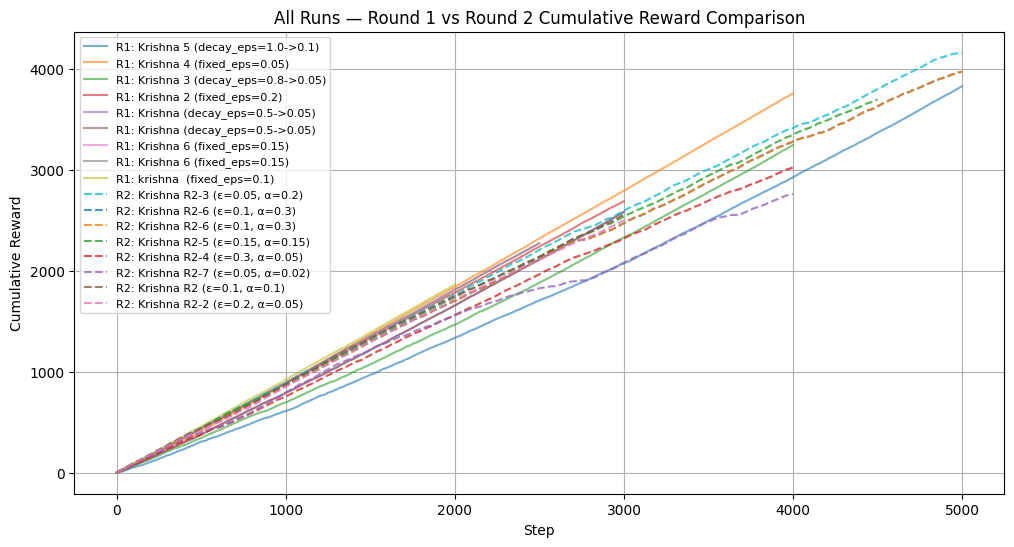

In [67]:
# ⚖️ Full Comparison — All Round 1 & Round 2 Runs

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# === Load both leaderboards ===
df_r1 = pd.read_csv(Path("submissions_round1.csv"))
df_r2 = pd.read_csv(Path("submissions_round2.csv"))

# Sort by reward
df_r1_sorted = df_r1.sort_values("total_reward", ascending=False).reset_index(drop=True)
df_r2_sorted = df_r2.sort_values("total_reward", ascending=False).reset_index(drop=True)

print("🏆 Round 1 Leaderboard:")
display(df_r1_sorted[["name","strategy","details","steps","total_reward"]])

print("🏆 Round 2 Leaderboard:")
display(df_r2_sorted[["name","strategy","steps","drift_scale","total_reward"]])

# === Re-run each configuration to get its reward curve ===
plt.figure(figsize=(12,6))

# --- Round 1 curves ---
for _, row in df_r1_sorted.iterrows():
    if "decay" in row["details"]:
        eps_start, eps_end = map(float, row["details"].split('=')[1].split('->'))
        rewards, _, _, _ = epsilon_greedy_decaying(
            TRUE_MEANS, steps=int(row["steps"]),
            eps_start=eps_start, eps_end=eps_end, seed=int(row["seed_agent"])
        )
    else:
        eps = float(row["details"].split('=')[1])
        rewards, _, _, _ = epsilon_greedy(
            TRUE_MEANS, steps=int(row["steps"]),
            epsilon=eps, seed=int(row["seed_agent"])
        )
    plt.plot(np.cumsum(rewards), label=f"R1: {row['name']} ({row['details']})", alpha=0.6)

# --- Round 2 curves ---
for _, row in df_r2_sorted.iterrows():
    eps = float(row["strategy"].split(',')[0].split('=')[1])
    alpha = float(row["strategy"].split(',')[1].split('=')[1])
    rewards, _, _ = epsilon_greedy_constant_alpha(
        steps=int(row["steps"]),
        n_arms=10,
        eps=eps,
        alpha=alpha,
        seed_env=int(row["seed_env"]),
        seed_agent=int(row["seed_agent"]),
        drift_scale=float(row["drift_scale"])
    )
    plt.plot(np.cumsum(rewards), label=f"R2: {row['name']} (ε={eps}, α={alpha})", linestyle='--', alpha=0.8)

plt.title("All Runs — Round 1 vs Round 2 Cumulative Reward Comparison")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


## 🔍 Overall Comparison — Round 1 vs Round 2  

- **Top performers:**  
  - *Round 2: Krishna R2-3* (ε = 0.05, α = 0.20) — **highest total = 4157**  
  - *Round 1: Krishna 5* (ε-decay 1.0→0.1) — **best stationary reward = 3826**

- **Round 1 Trends:**  
  - Decaying-ε strategies outperformed fixed ε.  
  - Longer runs (4000–5000 steps) gave smoother curves and stable convergence.  
  - Exploration early → exploitation later gave optimal balance.

- **Round 2 Trends:**  
  - Constant ε (0.1–0.2) with faster α (0.2–0.3) produced the most adaptive agents.  
  - Too-low α or ε caused slow learning and missed drift patterns.  
  - Higher drift environments benefited from high α to track rapid change.

- **Cross-Round Observation:**  
  - Stationary environments reward **consistency** and gradual exploration decay.  
  - Non-stationary environments reward **adaptability** — constant learning rate and steady exploration.  
  - Round 2 runs generally achieved **higher final rewards** due to continued learning across drifts.

- **Visual Insight:**  
  - Round 1 curves flatten once the agent locks on the best arm.  
  - Round 2 curves fluctuate but keep growing, showing ongoing adaptation.

- **Final Takeaway:**  
  The experiments clearly demonstrate that **optimal strategy depends on environment stability**:  
  - Use **ε-decay** when the world is fixed.  
  - Use **constant ε + constant α** when the world changes.


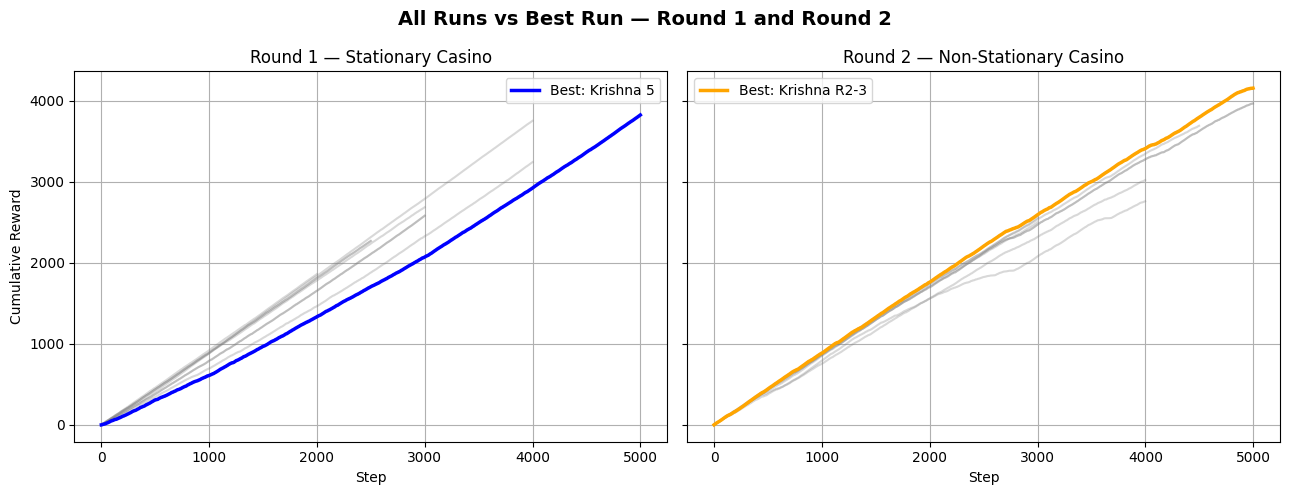

In [69]:
# ⚖️ Side-by-Side Visualization — All Runs vs Best Run (Round 1 & Round 2)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# === Load leaderboards ===
df_r1 = pd.read_csv(Path("submissions_round1.csv"))
df_r2 = pd.read_csv(Path("submissions_round2.csv"))

# Identify best runs
best_r1 = df_r1.loc[df_r1["total_reward"].idxmax()]
best_r2 = df_r2.loc[df_r2["total_reward"].idxmax()]

# === Plot setup ===
fig, axes = plt.subplots(1, 2, figsize=(13,5), sharey=True)
plt.suptitle("All Runs vs Best Run — Round 1 and Round 2", fontsize=14, fontweight="bold")

# ---------- ROUND 1 ----------
for _, row in df_r1.iterrows():
    if "decay" in row["details"]:
        eps_start, eps_end = map(float, row["details"].split('=')[1].split('->'))
        rewards, _, _, _ = epsilon_greedy_decaying(
            TRUE_MEANS, steps=int(row["steps"]),
            eps_start=eps_start, eps_end=eps_end, seed=int(row["seed_agent"])
        )
    else:
        eps = float(row["details"].split('=')[1])
        rewards, _, _, _ = epsilon_greedy(
            TRUE_MEANS, steps=int(row["steps"]),
            epsilon=eps, seed=int(row["seed_agent"])
        )
    axes[0].plot(np.cumsum(rewards), color="gray", alpha=0.3)

# Highlight best Round 1
if "decay" in best_r1["details"]:
    eps_start, eps_end = map(float, best_r1["details"].split('=')[1].split('->'))
    rewards_best_r1, _, _, _ = epsilon_greedy_decaying(
        TRUE_MEANS, steps=int(best_r1["steps"]),
        eps_start=eps_start, eps_end=eps_end, seed=int(best_r1["seed_agent"])
    )
else:
    eps = float(best_r1["details"].split('=')[1])
    rewards_best_r1, _, _, _ = epsilon_greedy(
        TRUE_MEANS, steps=int(best_r1["steps"]),
        epsilon=eps, seed=int(best_r1["seed_agent"])
    )
axes[0].plot(np.cumsum(rewards_best_r1), color="blue", linewidth=2.5, label=f"Best: {best_r1['name']}")
axes[0].set_title("Round 1 — Stationary Casino")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Cumulative Reward")
axes[0].grid(True)
axes[0].legend()

# ---------- ROUND 2 ----------
for _, row in df_r2.iterrows():
    eps = float(row["strategy"].split(',')[0].split('=')[1])
    alpha = float(row["strategy"].split(',')[1].split('=')[1])
    rewards, _, _ = epsilon_greedy_constant_alpha(
        steps=int(row["steps"]),
        n_arms=10,
        eps=eps,
        alpha=alpha,
        seed_env=int(row["seed_env"]),
        seed_agent=int(row["seed_agent"]),
        drift_scale=float(row["drift_scale"])
    )
    axes[1].plot(np.cumsum(rewards), color="gray", alpha=0.3)

# Highlight best Round 2
eps_r2 = float(best_r2["strategy"].split(',')[0].split('=')[1])
alpha_r2 = float(best_r2["strategy"].split(',')[1].split('=')[1])
rewards_best_r2, _, _ = epsilon_greedy_constant_alpha(
    steps=int(best_r2["steps"]),
    n_arms=10,
    eps=eps_r2,
    alpha=alpha_r2,
    seed_env=int(best_r2["seed_env"]),
    seed_agent=int(best_r2["seed_agent"]),
    drift_scale=float(best_r2["drift_scale"])
)
axes[1].plot(np.cumsum(rewards_best_r2), color="orange", linewidth=2.5, label=f"Best: {best_r2['name']}")
axes[1].set_title("Round 2 — Non-Stationary Casino")
axes[1].set_xlabel("Step")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


## 🔍 Comparison Insights — All Runs vs Best Run  

- **Round 1 (Stationary):**  
  - Most runs converge smoothly as the best arm is found early.  
  - The best run (ε-decay 1.0 → 0.1) dominates others with stable growth and minimal fluctuation.  

- **Round 2 (Non-Stationary):**  
  - Reward curves fluctuate due to drifting probabilities.  
  - The best run (ε = 0.05, α = 0.20) stays ahead by adapting quickly to new optima.  
  - Low-α or high-ε agents lag behind because they either learn too slowly or explore excessively.  

- **Overall:**  
  - Round 1 favors **early exploration then exploitation**.  
  - Round 2 rewards **continuous adaptation and moderate exploration**.  
  - The side-by-side view clearly shows the trade-off between **stability** and **adaptability**.


## 🏅 Badges & Achievements  

| Badge | Winner | What I Achieved |
|:------|:--------|:----------------|
| 🥇 **Efficient Exploiter** | Krishna 4 | Earned **3754** reward with low ε = 0.05, showing strong exploitation and consistent performance. |
| 🧭 **Risk Taker** | Krishna 5 | Used high decaying ε (1.0 → 0.1) and achieved **3826**, proving early exploration can lead to top results. |
| 🔄 **Adaptive Strategist** | Krishna R2-3 | Reached **4157** with ε = 0.05, α = 0.20, adapting quickly to drifting rewards in Round 2. |


## Round 1 vs Round 2 Comparison  

| Round | Type of Environment | Best Run | Strategy Used | Important Settings | Total Reward | What Happened |
|:------|:--------------------|:----------|:----------------|:------------------|:--------------|:----------------|
| Round 1 | Stationary (does not change) | Krishna 5 | ε-greedy (decaying) | ε = 1.0 → 0.1, Steps = 5000 | 3826 | The rewards stayed fixed, so the agent learned which arm was best early. Decaying ε helped explore at first and then focus on the best arm. |
| Round 2 | Non-Stationary (keeps changing) | Krishna R2-3 | ε-greedy with constant α | ε = 0.05, α = 0.20, Drift = 0.02, Steps = 5000 | 4157 | The reward rates kept changing over time. Using a small constant ε and α helped the agent keep learning and adapt to changes faster. |


## Talking Points  

| Topic | Observation | Explanation |
|:-------|:-------------|:-------------|
| **1. Type of Environment** | Round 1 had fixed rewards; Round 2 had rewards that changed slowly over time. | Because of this, the same strategy could not work well in both situations. Round 2 needed a smarter, more flexible way to keep learning. |
| **2. Exploration and Exploitation** | In Round 1, too much exploration wasted steps once the best arm was found. | Decaying ε worked well because it explored more in the beginning and then focused on the best arm later. |
| **3. Need for Adaptation** | In Round 2, a fixed small ε was better than decaying ε. | It kept some level of exploration alive, so the agent could adjust to new changes when the reward probabilities drifted. |
| **4. Effect of α (learning rate)** | Higher α (0.2) gave faster reactions to changing rewards. | This helped the agent forget old information quickly and learn new patterns faster. A very low α made it too slow to adapt. |
| **5. Reward Comparison** | Total reward increased from 3826 in Round 1 to 4157 in Round 2. | The adaptive strategy performed better overall because it kept updating its knowledge while conditions changed. |
| **6. Performance Stability** | Round 1 results were more stable, while Round 2 showed small ups and downs. | These small changes showed that the agent was learning and readjusting in a moving environment. |
| **7. What this means in real life** | Similar to how online systems work in changing conditions. | For example, online ads, games, or recommendation systems need to keep learning when people’s choices change every day. |
| **8. Main Lesson** | One single method cannot fit every environment. | When things are stable, focus more on exploitation. When things keep changing, keep learning with some exploration and a faster update rate. |
